<h1 style = "font-size:45px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">STOCK PRICE PREDICTION</h1>

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">1. Import Required Libraries 📚</h1></span>

In [311]:
import itertools
import math
import time
import operator
import datetime
import requests
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from math import sqrt

import keras
import h5py
import h2o
from h2o.automl import H2OAutoML
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
# from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [312]:
# Define the list of training files
train_files = ['/kaggle/input/kriti-stock-market-prediction/1_train.csv',
 '/kaggle/input/kriti-stock-market-prediction/4_train.csv',
'/kaggle/input/kriti-stock-market-prediction/3_train.csv',
'/kaggle/input/kriti-stock-market-prediction/2_train.csv']
# Create an empty dictionary to store the models
models = {}


# Loop through each training file
for file in train_files:
    # Load the training data
    train_data = pd.read_csv(file)
    print(train_data.head())
#     print(train_data.shape)

         Date  Open  High   Low  Close  Adj Close        Volume
0  2010-06-29  9.50  9.47  9.23   9.04       7.93  1.133345e+09
1  2010-06-30  9.25  9.22  9.00   8.70       7.52  7.394520e+08
2  2010-07-01  9.01  9.02  8.63   8.94       7.45  1.022896e+09
3  2010-07-02  8.98  8.96  8.74   8.85       7.68  6.938428e+08
4  2010-07-06  9.13  9.13  8.61   9.36       7.68  6.152356e+08
         Date  Open  High   Low  Close  Adj Close       Volume
0  29-06-2010  1.05  1.67  1.24   1.69       1.64  281494500.0
1  30-06-2010  1.64  2.02  1.56   1.43       1.69  257806500.0
2  01-07-2010  1.85  1.83  1.24   1.46       1.26  123282000.0
3  02-07-2010  1.56  1.59  1.18   1.14       1.27   77097000.0
4  06-07-2010  1.19  1.19  1.30   0.94       1.05  103003500.0
         Date  Open  High   Low  Close  Adj Close      Volume
0  2010-06-29  2.76  2.63  2.48   2.59       2.38  66080800.0
1  2010-06-30  2.62  2.54  2.73   2.46       2.15  62307200.0
2  2010-07-01  2.48  2.46  2.55   2.66       2.46  7

In [313]:
train = []

test = pd.read_csv('/kaggle/input/kriti-stock-market-prediction/test.csv')
test['Date'] = pd.to_datetime(test.Date)
sub = pd.DataFrame(test['ID'])
sub['Close'] = np.nan
test.drop(['ID'], axis=1, inplace=True)
test['is_test'] = 1 # we will be combining train and test dataframes

for i in range(4):
    train.append(pd.read_csv('/kaggle/input/kriti-stock-market-prediction/'+f'{i+1}_train.csv'))
    train[i]['Date'] = pd.to_datetime(train[i].Date)
    train[i]['Company'] = i+1
    train[i]['is_test'] = 0 
    train[i] = pd.concat([train[i], test[test['Company'] == i+1]])
    train[i].sort_values(by='Date', inplace = True)
    train[i].drop(['Company'], axis=1, inplace=True)

In [314]:
train[0].head()

,Date,Open,High,Low,Close,Adj Close,Volume,is_test
0,2010-06-29,9.50,9.47,9.23,9.04,7.93,1.133345e+09,0
1,2010-06-30,9.25,9.22,9.00,8.70,7.52,7.394520e+08,0
2,2010-07-01,9.01,9.02,8.63,8.94,7.45,1.022896e+09,0
3,2010-07-02,8.98,8.96,8.74,8.85,7.68,6.938428e+08,0
4,2010-07-06,9.13,9.13,8.61,9.36,7.68,6.152356e+08,0


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">2. Data Preprocessing</h1></span>

In [315]:
# Creating lags using last 15 days Open prices, Adj Close prices
for i in range(4):
    for j in range(15):
        train[i][f'Lag_Open_{j+1}'] = train[i]['Open'].shift(j+1)
        train[i][f'Lag_Adj_Close_{j+1}'] = train[i]['Adj Close'].shift(j+1)    

In [316]:
# Creating a feature of sum of last 2 days Volume
for i in range(4):
    for j in range(2):
        train[i][f'Lag_Volume_{j+1}'] = train[i]['Volume'].shift(j+1)
    train[i]['Lag_Volume'] = train[i]['Lag_Volume_1'] + train[i]['Lag_Volume_2']
    train[i].drop(['Lag_Volume_1', 'Lag_Volume_2'], axis=1, inplace=True)

In [317]:
# Creating lags using last 15 days High and Low price and Volume
for i in range(4):
    for j in range(15):
        train[i][f'Lag_Volume_{j+1}'] = train[i]['Volume'].shift(j+1)
        train[i][f'Lag_High_{j+1}'] = train[i]['High'].shift(j+1)
        train[i][f'Lag_Low_{j+1}'] = train[i]['Low'].shift(j+1)  

In [318]:
# Creating features Day of Week(removed), Date of Month(removed), Week of Year, Month, Year
for i in range(4):
    train[i]['Day_of_Week'] = train[i]['Date'].dt.dayofweek
    train[i]['Date_of_Month'] = train[i]['Date'].dt.day
    train[i]['Week_of_Year'] = train[i]['Date'].dt.week
    train[i]['Month'] = train[i]['Date'].dt.month
    train[i]['Year'] = train[i]['Date'].dt.year

In [319]:
# Creating features Quarter, (is_month_start, is_month_end, is_quarter_start, is_quarter_end, is_year_end)(removed)

for i in range(4):
    train[i]['Quarter_of_Year'] = train[i]['Date'].dt.quarter
    train[i]['is_month_start'] = train[i]['Date'].dt.is_month_start.astype(int)
    train[i]['is_month_end'] = train[i]['Date'].dt.is_month_end.astype(int)
    train[i]['is_quarter_start'] = train[i]['Date'].dt.is_quarter_start.astype(int)
    train[i]['is_quarter_end'] = train[i]['Date'].dt.is_quarter_end.astype(int)
    train[i]['is_year_end'] = train[i]['Date'].dt.is_year_end.astype(int)

In [320]:
# Adding feature (High+Low)/2, (High*Low)**0.5
for i in range(4):
    train[i]['HighnLow'] = (train[i]['High'] + train[i]['Low'])/2
    train[i]['sqrtHighLow'] = (train[i]['High']*train[i]['Low'])**0.5

In [321]:
# Creating feature using scaled volume
for i in range(4):
    scaler = MinMaxScaler()
    volume_scaled = scaler.fit_transform(pd.DataFrame(train[i]['Volume']))
    train[i]['Volume_scaled'] = volume_scaled
    train[i].drop(['Volume'], 1, inplace=True)

#### 2.1 Handling cyclic features like month
Doesn't work for day of week, date of month, month, week of year, graph comes linear not circular

<Figure size 432x288 with 0 Axes>

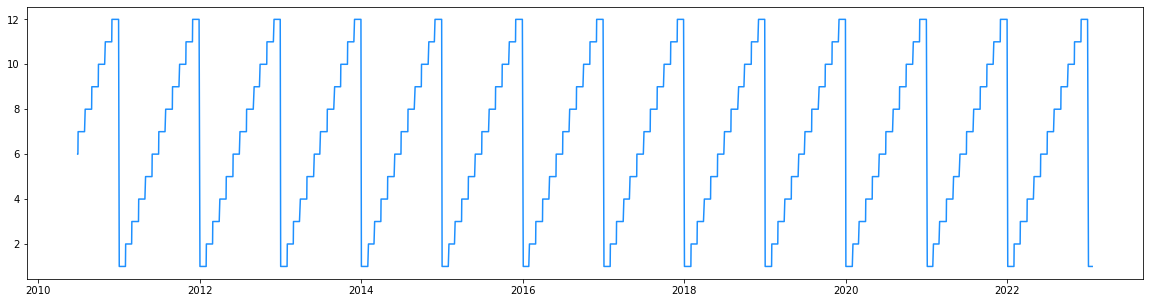

<Figure size 432x288 with 0 Axes>

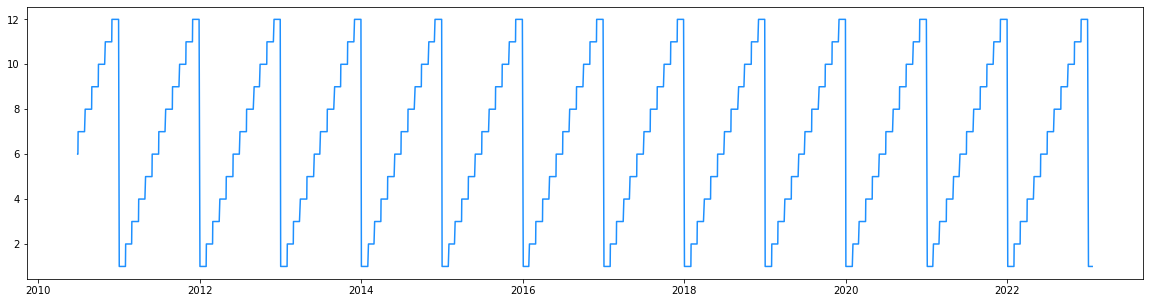

<Figure size 432x288 with 0 Axes>

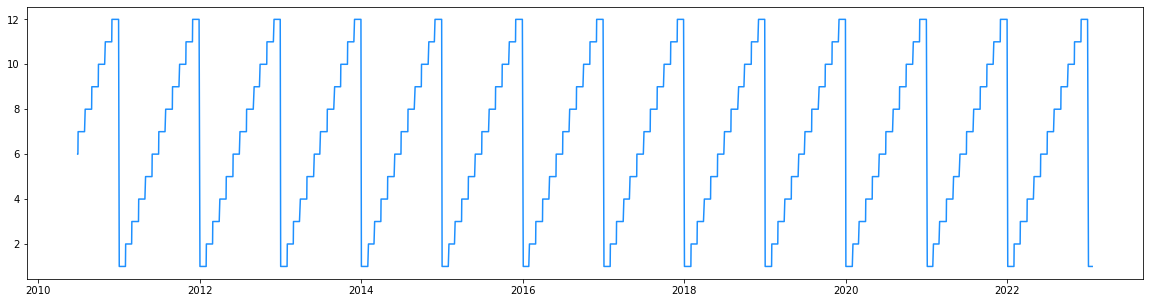

<Figure size 432x288 with 0 Axes>

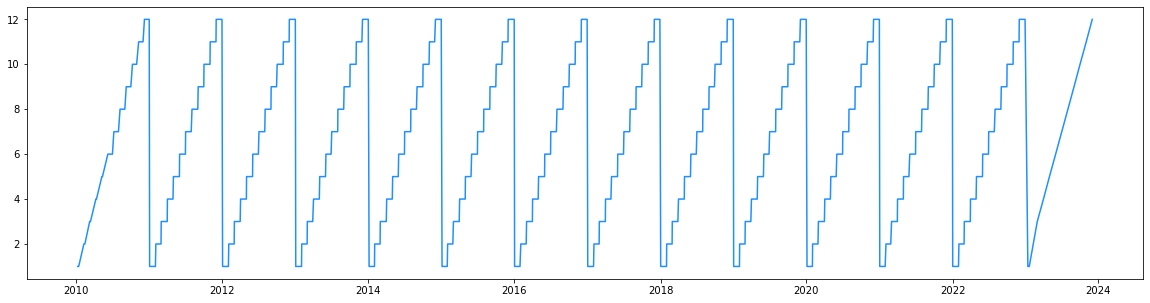

In [322]:
for i in range(4):
    plt.figure()
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(train[i]['Date'], train[i]['Month'], color='dodgerblue')
    plt.show()

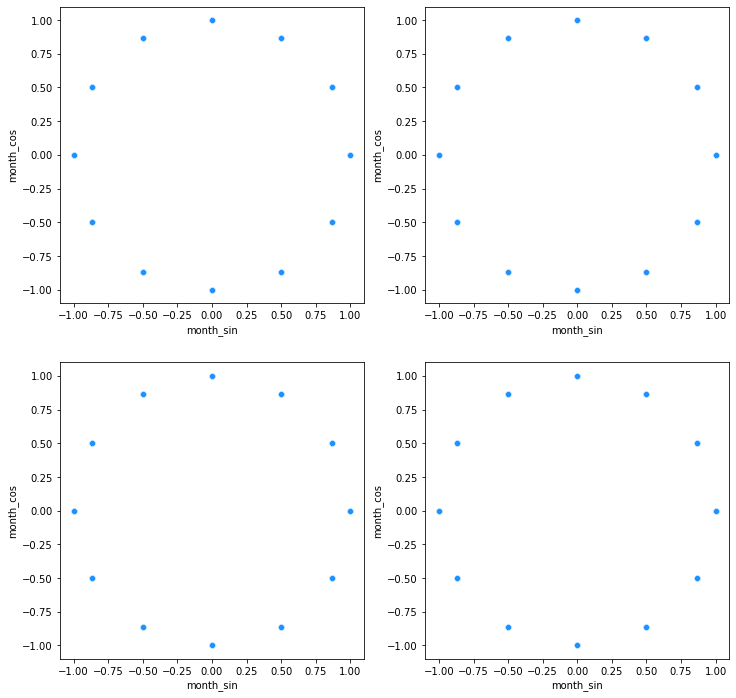

In [323]:
month_in_year = 12

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for i in range(4):
    day_in_week = train[i]['Day_of_Week'].nunique()
    date_in_month = train[i]['Date_of_Month'].nunique()
    week_in_year = train[i]['Week_of_Year'].nunique()
    
    train[i]['month_sin'] = np.sin(2*np.pi*train[i]['Month']/month_in_year)
    train[i]['month_cos'] = np.cos(2*np.pi*train[i]['Month']/month_in_year)
    train[i]['day_sin'] = np.sin(2*np.pi*train[i]['Day_of_Week']/day_in_week)
    train[i]['day_cos'] = np.sin(2*np.pi*train[i]['Day_of_Week']/day_in_week)
    train[i]['date_sin'] = np.sin(2*np.pi*train[i]['Date_of_Month']/date_in_month)
    train[i]['date_cos'] = np.sin(2*np.pi*train[i]['Date_of_Month']/date_in_month)
    train[i]['week_sin'] = np.sin(2*np.pi*train[i]['Week_of_Year']/week_in_year)
    train[i]['week_cos'] = np.sin(2*np.pi*train[i]['Week_of_Year']/week_in_year)
    sns.scatterplot(x=train[i].month_sin, y=train[i].month_cos, color='dodgerblue', ax=ax[i//2][i%2])

plt.show()

In [324]:
train[0].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'is_test',
       'Lag_Open_1', 'Lag_Adj_Close_1', 'Lag_Open_2',
       ...
       'sqrtHighLow', 'Volume_scaled', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'date_sin', 'date_cos', 'week_sin', 'week_cos'],
      dtype='object', length=105)

In [325]:
# Dropping the Date and Month
# Moving the Close column to the right side of the dataframe

for i in range(4):
    train[i].drop(['Date', 'Month'], axis=1, inplace=True)
    train[i] = train[i].reindex(columns = [col for col in train[i].columns if col != 'Close'] + ['Close'])

In [326]:
# Drop the rows containing null values created due to creation of lags
for i in range(4):
    print(len(train[0][train[0][train[0]['is_test'] == 0].isna().sum(axis=1)>0]))

15
15
15
15


Therefore, first 15 rows of each dataframes need to be dropped

In [327]:
for i in range(4):
    train[i] = train[i].iloc[15:]
    print(len(train[0][train[0][train[0]['is_test'] == 0].isna().sum(axis=1)>0])) # check if these rows have been dropped successfully

0
0
0
0


In [328]:
train[0].columns

Index(['Open', 'High', 'Low', 'Adj Close', 'is_test', 'Lag_Open_1',
       'Lag_Adj_Close_1', 'Lag_Open_2', 'Lag_Adj_Close_2', 'Lag_Open_3',
       ...
       'Volume_scaled', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'date_sin', 'date_cos', 'week_sin', 'week_cos', 'Close'],
      dtype='object', length=103)

#### Preprocessing of the data has been completed.

#### 2.2 MI score for feature selection and creation

In [329]:
# Separating train and test dataframes
tests = []
for i in range(4):
    tests.append(train[i][train[i]['is_test'] == 1])
    train[i] = train[i][train[i]['is_test'] == 0]
    tests[i].drop(['is_test'], axis=1, inplace=True)
    train[i].drop(['is_test'], axis=1, inplace=True)

In [330]:
# Calculating MI score for the features
from sklearn.feature_selection import mutual_info_regression

mi_score = []

for i in range(4):
    mi_score.append(mutual_info_regression(train[i].drop(['Close'], 1), train[i]['Close']))

In [331]:
# Generating a list of columns to drop
cols_to_drop = []
for i in range(4):  
    inner_list = []
    print(f"=======Company {i+1}=======")
    for j in range(len(train[i].columns)-1):
        if mi_score[i][j]<2:
            inner_list.append(train[i].columns[j])
            print(train[i].columns[j], ":", mi_score[i][j])
    cols_to_drop.append(inner_list)

=======Company 1=======
Lag_Volume : 0.6433030484711031
Lag_Volume_1 : 0.5654562348658789
Lag_Volume_2 : 0.5542382314754004
Lag_Volume_3 : 0.5521934377114226
Lag_Volume_4 : 0.5600742143400002
Lag_Volume_5 : 0.551254936008732
Lag_Volume_6 : 0.5787504431741635
Lag_Volume_7 : 0.5458358598245914
Lag_Volume_8 : 0.5440673170007688
Lag_Volume_9 : 0.5410247828824293
Lag_Volume_10 : 0.5441720202328781
Lag_Volume_11 : 0.5594936763031244
Lag_Volume_12 : 0.5606422847196839
Lag_Volume_13 : 0.55455620662927
Lag_Volume_14 : 0.5405729273855044
Lag_Volume_15 : 0.5798074027173996
Day_of_Week : 0.0
Date_of_Month : 0.0
Week_of_Year : 1.2107724505732134
Year : 1.7509207296576845
Quarter_of_Year : 0.4591092753699859
is_month_start : 0.0
is_month_end : 0.000803791973549739
is_quarter_start : 0.0
is_quarter_end : 0.00023699989742720362
is_year_end : 0.0009579474694760837
Volume_scaled : 0.5772677510610604
month_sin : 0.5453791435693667
month_cos : 0.5002019504107924
day_sin : 0.0
day_cos : 0.0
date_sin : 0.0


In [332]:
# Dropping the above listed features
for i in range(4):
    train[i].drop(cols_to_drop[i], 1, inplace=True)
    tests[i].drop(cols_to_drop[i], 1, inplace=True)

In [333]:
train[0].head()

,Open,High,Low,Adj Close,Lag_Open_1,Lag_Adj_Close_1,Lag_Open_2,Lag_Adj_Close_2,Lag_Open_3,Lag_Adj_Close_3,...,Lag_Low_12,Lag_High_13,Lag_Low_13,Lag_High_14,Lag_Low_14,Lag_High_15,Lag_Low_15,HighnLow,sqrtHighLow,Close
15,9.67,9.44,9.12,7.75,8.63,7.63,8.86,7.49,8.92,7.59,...,8.74,9.02,8.63,9.22,9.00,9.47,9.23,9.280,9.278621,9.22
16,9.07,9.30,8.97,8.01,9.67,7.75,8.63,7.63,8.86,7.49,...,8.61,8.96,8.74,9.02,8.63,9.22,9.00,9.135,9.133510,9.30
17,9.25,9.31,9.14,7.93,9.07,8.01,9.67,7.75,8.63,7.63,...,8.99,9.13,8.61,8.96,8.74,9.02,8.63,9.225,9.224608,9.06
18,9.24,9.34,9.33,7.95,9.25,7.93,9.07,8.01,9.67,7.75,...,9.09,9.36,8.99,9.13,8.61,8.96,8.74,9.335,9.334999,9.56
19,9.61,9.51,9.27,8.09,9.24,7.95,9.25,7.93,9.07,8.01,...,8.95,9.38,9.09,9.36,8.99,9.13,8.61,9.390,9.389233,9.29


In [334]:
train[0].shape

(2515, 67)

In [335]:
corrs = []
for i in range(4):
    corrs.append(train[i].corr())

In [336]:
corrs[0][abs(corrs[0]['Close'])<0.01] # ['Day_of_Week', 'Date_of_Month', 'is_month_start', 'is_month_end', 
# 'is_quarter_start', 'is_quarter_end', 'is_year_start', is_year_end']

,Open,High,Low,Adj Close,Lag_Open_1,Lag_Adj_Close_1,Lag_Open_2,Lag_Adj_Close_2,Lag_Open_3,Lag_Adj_Close_3,...,Lag_Low_12,Lag_High_13,Lag_Low_13,Lag_High_14,Lag_Low_14,Lag_High_15,Lag_Low_15,HighnLow,sqrtHighLow,Close


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">3. Creating Train-Val-Test splits</h1></span>

In [337]:
from sklearn.model_selection import train_test_split

X_train = []
y_train = []
X_val = []
y_val = []

for i in range(4):
    X1, X2, y1, y2 = train_test_split(train[i].drop(['Close'], axis=1),
                                                        train[i]['Close'],
                                                        test_size=0.2,
                                                        random_state=42)
    X_train.append(X1)
    X_val.append(X2)
    y_train.append(y1)
    y_val.append(y2)

In [338]:
X_train[0].shape, train[0].shape

((2012, 66), (2515, 67))

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">4. Training</h1></span>

#### 1. Linear Regression

In [339]:
models = []
# actual target values
train_actual = []
val_actual = []
# predictions of the model
train_preds = [] 
val_preds = []

for i in range(4):
    model = LinearRegression()
    model.fit(X_train[i], y_train[i])
    models.append(model)
    print(f"TRAIN RMSE (Company {i+1}): ", mean_squared_error(model.predict(X_train[i]), y_train[i])**0.5)
    print(f"VALIDATION RMSE (Company {i+1}): ", mean_squared_error(model.predict(X_val[i]), y_val[i])**0.5)
    train_preds.extend(model.predict(X_train[i]))
    val_preds.extend(model.predict(X_val[i]))
    train_actual.extend(y_train[i])
    val_actual.extend(y_val[i])

TRAIN RMSE (Company 1):  0.6618539398970025
VALIDATION RMSE (Company 1):  0.6647040808888375
TRAIN RMSE (Company 2):  0.9753984704986942
VALIDATION RMSE (Company 2):  0.9553529405279763
TRAIN RMSE (Company 3):  0.8694079753260202
VALIDATION RMSE (Company 3):  0.9333537308484467
TRAIN RMSE (Company 4):  0.8276343662969439
VALIDATION RMSE (Company 4):  0.849127464362089


In [340]:
# Calculating overall scores of all 4 companies combined
print(f"OVERALL TRAIN RMSE: ", mean_squared_error(train_actual, train_preds)**0.5)
print(f"OVERALL VALIDATION RMSE: ", mean_squared_error(val_actual, val_preds)**0.5)

OVERALL TRAIN RMSE:  0.8411750242732796
OVERALL VALIDATION RMSE:  0.8582973543225608


In [341]:
# Generating test predictions
test_preds = []
for i in range(4):
    test_preds.extend(models[i].predict(tests[i].drop(['Close'], axis=1)))

##### Creating submission file

In [342]:
sub['ID'] = test.sort_values(by=['Company', 'Date']).index
sub['Close'] = test_preds

In [343]:
sub.to_csv('After_mi_score_nolead.csv', index=False)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">2nd Model</h1></span>

In [344]:
# Define the list of training files
train_files = ['/kaggle/input/kriti-stock-market-prediction/1_train.csv',
 '/kaggle/input/kriti-stock-market-prediction/2_train.csv',
'/kaggle/input/kriti-stock-market-prediction/3_train.csv',
'/kaggle/input/kriti-stock-market-prediction/4_train.csv']

Company-1


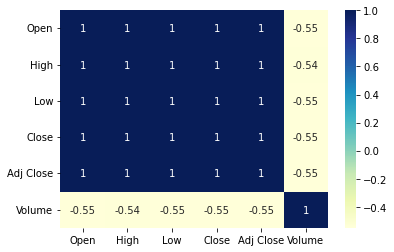

Company-2


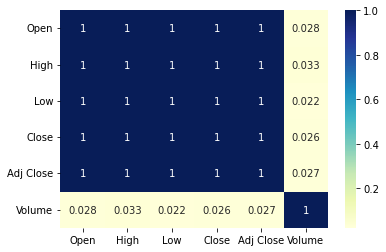

Company-3


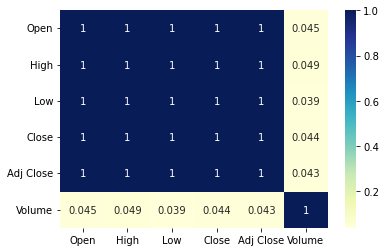

Company-4


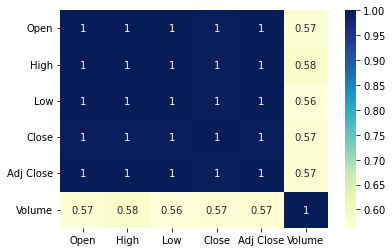

In [345]:
# Create an empty dictionary to store the models and scalers
models = {}
scalers={}

for i, file in enumerate(train_files):
    train_data = pd.read_csv(file)
    print("Company-{}".format(i+1))
    dataplot = sns.heatmap(train_data.corr(), cmap="YlGnBu", annot=True)
    plt.show()

From the correlation plot it is clear that we need to use only one among the heavily correlated features for prediction viz Adj Close.

In [346]:

# Create an empty dictionary to store the models and scalers
models = {}
scalers={}
# Loop through each training file
for i, file in enumerate(train_files):

    # Define the features
    X_train = train_data[['Adj Close']]
    sc={}
    
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train['Adj Close'] = min_max_scaler.fit_transform(X_train['Adj Close'].values.reshape(-1,1))
    sc['Adj Close']=min_max_scaler
    
    
    y_train = train_data['Close']
    min_max_scaler = preprocessing.MinMaxScaler()
    y_train = min_max_scaler.fit_transform(y_train.values.reshape(-1,1))
    sc['Close']=min_max_scaler
    
    

    # Create the linear regression model
    model = LinearRegression()

    # Fit the model to the training data
    model.fit(X_train, y_train)
    temp_preds = model.predict(X_train)
    temp_preds = sc['Close'].inverse_transform(np.array([temp_preds]).reshape(1,-1))
    X_train['close_preds'] = temp_preds[0]
    X_train['Close'] = train_data['Close']
    X_train['Adj Close'] = (sc['Adj Close'].inverse_transform(np.array([X_train['Adj Close']]).reshape(1,-1)))[0]

    # Store the model in the dictionary using the company ID as the key
    models[i+1] = model
    scalers[i+1]=sc

In [347]:
# Load the testing data
test_data = pd.read_csv('/kaggle/input/kriti-stock-market-prediction/test.csv')

#Create a dataframe for the submission
submission_df = pd.DataFrame(columns=['ID', 'Close'])
submission_df['ID'] = test_data['ID']

In [348]:
# Loop through each row of the testing data
for i, row in test_data.iterrows():
    # Get the company ID
    company_id = row['Company']
    
    # Get the corresponding model for the current company ID
    model = models[company_id]
    slr = scalers[company_id]

    # Make predictions on the current row of testing data
    X_test = row[['Adj Close']]
    X_test['Adj Close']= slr['Adj Close'].transform(np.array([X_test['Adj Close']]).reshape(1,-1))
    X_test = X_test[['Adj Close']].to_numpy().reshape(1, -1)
    row_id = row['ID']
    y_pred = model.predict(X_test)
    y_pred = slr['Close'].inverse_transform(np.array([y_pred]).reshape(1,-1))
    submission_df.loc[row_id, 'Close'] = y_pred[0]

In [349]:
submission_df.to_csv("submission_lr_AdjClose.csv", index=False)

# Ensembling

In [350]:
sub = sub.sort_values(['ID']).reset_index().drop(['index'], 1)

In [351]:
final = pd.DataFrame()
final['ID'] = sub['ID']
final['Close']=0.55*sub['Close']+0.45*submission_df['Close']